In [1]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

In [12]:
class PlannerState(TypedDict):
    messages : Annotated[List[HumanMessage | AIMessage],"the messages in conversation"]
    city: str
    interests: List[str]
    itinerary: str

In [3]:
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

NameError: name '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' is not defined

In [5]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature = 0,
    groq_api_key = "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",
    model_name = "llama-3.3-70b-versatile"
)
# llm.invoke('what is multi ai agents')

In [11]:
!pip install langchain_groq

  Using cached langchain_groq-0.3.6-py3-none-any.whl.metadata (2.6 kB)
  Using cached groq-0.30.0-py3-none-any.whl.metadata (16 kB)
Using cached langchain_groq-0.3.6-py3-none-any.whl (16 kB)
Using cached groq-0.30.0-py3-none-any.whl (131 kB)

   ---------------------------------------- 0/2 [groq]
   ---------------------------------------- 2/2 [langchain_groq]



In [13]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my trip day wise list in each day title ,location and discription."),
])

define agenet function

In [14]:
def input_city(state: PlannerState) -> PlannerState:
    print("please enter the city you want to visit for your day trip:")
    user_message = input('your input:')
    return {
        **state,
        "city":user_message,
        "messages":state['messages'] + [HumanMessage(content=user_message)],

    }
def input_interest(state: PlannerState) -> PlannerState:
    print(f"Please enter your interest for the trip to: {state['city']} (comma-separated): ")
    user_message = input("Your Input: ")
    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(",")],
        "messages": state['messages'] + [HumanMessage(content=user_message)]
    }

def create_itinerary(state: PlannerState) -> PlannerState:
    print(f"Creating an itinerary for {state['city']} based on interests: {', '.join(state['interests'])}")
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=','.join(state['interests'])))
    print("\nFinal Itinerary: ")
    print(response.content)
    return {
        **state,
        "messages": state['messages'] + [AIMessage(content=response.content)],
        "itinerary": response.content,
    }

create and compile workflow graph

In [15]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city",input_city)
workflow.add_node("input_interest",input_interest)
workflow.add_node("create_itinerary",create_itinerary)

workflow.set_entry_point('input_city')

workflow.add_edge("input_city","input_interest")
workflow.add_edge('input_interest','create_itinerary')
workflow.add_edge('create_itinerary',END)

app = workflow.compile()

display the graph structure

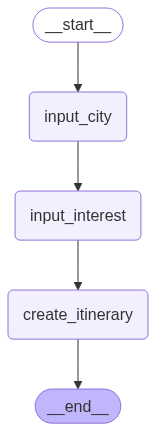

In [16]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

defining function that runs the graph

In [17]:
def travel_planner(user_request: str):
    print(f"Initial request {user_request}\n")
    state = {
        "messages":[HumanMessage(content=user_request)],
        "city":"",
        "interests":[],
        "itinerary": "",
    }
    for output in app.stream(state):
        pass

In [18]:
user_request = "I want to plan a two day trip "
travel_planner(user_request)

Initial request I want to plan a two day trip 

please enter the city you want to visit for your day trip:
Please enter your interest for the trip to: delhi (comma-separated): 
Creating an itinerary for delhi based on interests: red ford, taj

Final Itinerary: 
Here's a day trip itinerary for Delhi based on your interests in Red Fort and Taj Mahal:

* **Day 1: Delhi Exploration**
  * Location: Red Fort, Chandni Chowk
  * Description: Start your day with a visit to the historic Red Fort, a UNESCO World Heritage Site. Explore the fort's impressive architecture, museums, and gardens. Afterward, take a stroll through the bustling streets of Chandni Chowk, one of the oldest markets in Delhi.

* **Day 2: Taj Mahal Adventure**
  * Location: Taj Mahal, Agra
  * Description: Take a day trip to Agra to visit the breathtaking Taj Mahal, one of the Seven Wonders of the World. Learn about the monument's rich history and admire its stunning beauty. You can also explore other nearby attractions, such